# Street microgrid

In [1]:
# basic libraries
import pandas as pd
import numpy as np

# viz
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# other useful
from datetime import datetime, timedelta
from tqdm import tqdm, trange

# ML
from sklearn.cluster import KMeans



The idea is to investigate what could be done to make a housing estate as energy independent as possible?

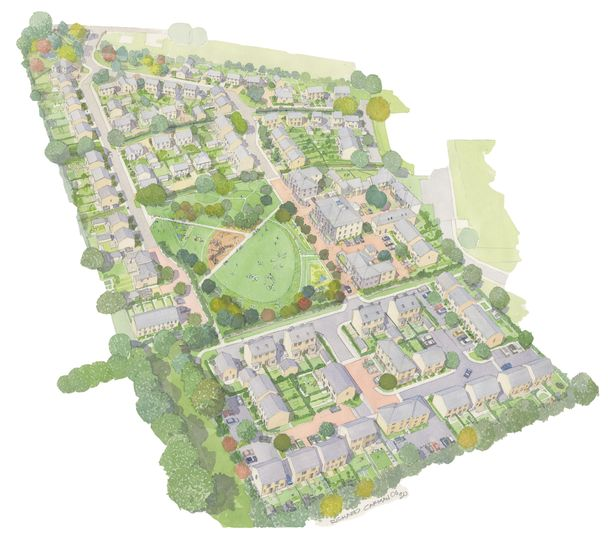

In [2]:
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\smart meter'
Image(dirpath + '/0_Bodmin-Aerial3smallrgb.jpg', width=1000, height=800)
# https://www.cornwalllive.com/news/cornwall-news/bodmin-housing-development-include-168-4309406

Initial part is some EDA and trying to clean data

In [3]:
# smart meter data - from a kaggle dataset
smdpath = dirpath+'/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces'

smart_meter_data = pd.read_csv(smdpath+'/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv', 
                               parse_dates=['DateTime'],
                               dayfirst=True,
                               usecols=['DateTime', 'KWH/hh (per half hour) '] )

smart_meter_data['KWH/hh (per half hour) '].fillna(0, inplace=True)
smart_meter_data['KWH/hh (per half hour) '].replace('Null', 0.0, inplace=True)
smart_meter_data['KWH/hh (per half hour) '] = smart_meter_data['KWH/hh (per half hour) '].astype(float)
smart_meter_data['house'] = 1

smart_meter_data['Date'] = smart_meter_data['DateTime'].dt.strftime('%Y-%m-%d')
smart_meter_data['Date'] = pd.to_datetime(smart_meter_data['Date'], dayfirst=True)

smart_meter_data = smart_meter_data.drop_duplicates(subset=['DateTime'], keep='first')

# reduce to one year
smart_meter_data = smart_meter_data[smart_meter_data['Date'] > '2012-12-31']
smart_meter_data = smart_meter_data[smart_meter_data['Date'] < '2014-01-01']

smart_meter_data.shape

smart_meter_data = smart_meter_data[['Date', 'DateTime', 'KWH/hh (per half hour) ']]
smart_meter_data.columns = ['Date', 'DateTime', 'h1']

In [4]:
smart_meter_data

,Date,DateTime,h1
3840,2013-01-01,2013-01-01 00:00:00,0.219
3841,2013-01-01,2013-01-01 00:30:00,0.241
3842,2013-01-01,2013-01-01 01:00:00,0.191
3843,2013-01-01,2013-01-01 01:30:00,0.235
3844,2013-01-01,2013-01-01 02:00:00,0.182
...,...,...,...
21367,2013-12-31,2013-12-31 21:30:00,0.451
21368,2013-12-31,2013-12-31 22:00:00,0.456
21369,2013-12-31,2013-12-31 22:30:00,0.402
21370,2013-12-31,2013-12-31 23:00:00,0.491


In [5]:
smart_meter_data.dtypes

Date        datetime64[ns]
DateTime    datetime64[ns]
h1                 float64
dtype: object

In [6]:
# get first N houses
for i in trange(2, 169):

    h2 = pd.read_csv(smdpath+'/Power-Networks-LCL-June2015(withAcornGps)v2_'+str(i)+'.csv', 
                                   parse_dates=['DateTime'],
                                   dayfirst=True,
                                   usecols=['DateTime', 'KWH/hh (per half hour) '] )

    h2['KWH/hh (per half hour) '].fillna(0, inplace=True)
    h2['KWH/hh (per half hour) '].replace('Null', 0.0, inplace=True)
    h2['KWH/hh (per half hour) '] = h2['KWH/hh (per half hour) '].astype(float)
    h2['house'] = 1

    h2['Date'] = h2['DateTime'].dt.strftime('%Y-%m-%d')
    h2['Date'] = pd.to_datetime(h2['Date'], dayfirst=True)

    h2 = h2.drop_duplicates(subset=['DateTime'], keep='first')

    # reduce to one year
    h2 = h2[h2['Date'] > '2012-12-31']
    h2 = h2[h2['Date'] < '2014-01-01']

    h2 = h2[['DateTime', 'KWH/hh (per half hour) ']]
    h2.columns = ['DateTime', 'h'+str(i)]
    #h2.shape
    
    smart_meter_data = pd.merge(smart_meter_data, h2, how='left', on='DateTime')

100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [56:50<00:00, 20.42s/it]


In [7]:
smart_meter_data

,Date,DateTime,h1,h2,h3,h4,h5,h6,h7,h8,...,h159,h160,h161,h162,h163,h164,h165,h166,h167,h168
0,2013-01-01,2013-01-01 00:00:00,0.219,0.006,0.093,0.073,0.107,0.235,0.032,0.076,...,0.100,0.168,0.240,0.076,0.065,0.155,0.209,0.151,0.684,0.105
1,2013-01-01,2013-01-01 00:30:00,0.241,0.017,0.068,0.059,0.103,0.201,0.034,0.075,...,0.095,0.265,0.318,0.053,0.127,0.111,0.230,0.165,0.536,0.087
2,2013-01-01,2013-01-01 01:00:00,0.191,0.059,0.078,0.069,0.103,0.202,0.013,0.073,...,0.059,0.160,0.328,0.037,0.082,0.167,0.187,0.387,0.377,0.050
3,2013-01-01,2013-01-01 01:30:00,0.235,0.000,0.228,0.059,0.130,0.162,0.043,0.073,...,0.084,0.198,0.222,0.036,0.106,0.091,0.109,0.082,0.387,0.045
4,2013-01-01,2013-01-01 02:00:00,0.182,0.000,0.097,0.088,0.078,0.175,0.069,0.072,...,0.098,0.159,0.308,0.051,0.097,0.065,0.168,0.051,0.645,0.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2013-12-31,2013-12-31 21:30:00,0.451,0.056,0.096,0.173,0.140,0.710,0.093,0.087,...,0.142,0.553,0.129,0.247,0.482,0.331,0.308,0.190,1.351,0.095
17516,2013-12-31,2013-12-31 22:00:00,0.456,0.017,0.107,0.166,0.158,0.265,0.104,0.095,...,0.123,0.641,0.164,0.260,0.560,0.237,0.269,0.487,1.954,0.107
17517,2013-12-31,2013-12-31 22:30:00,0.402,0.015,0.055,0.279,0.157,0.232,0.083,0.057,...,0.102,0.613,0.109,0.232,0.425,0.172,0.269,0.147,1.939,0.128
17518,2013-12-31,2013-12-31 23:00:00,0.491,0.027,0.066,0.142,0.124,0.172,0.110,0.033,...,0.102,0.585,0.160,0.258,0.520,0.148,0.182,0.264,1.366,0.056


[[0.219     0.241     0.191     ... 0.402     0.491     0.452    ]
 [0.006     0.017     0.059     ... 0.015     0.027     0.006    ]
 [0.093     0.068     0.078     ... 0.055     0.066     0.057    ]
 ...
 [0.151     0.165     0.387     ... 0.147     0.264     0.152    ]
 [0.684     0.536     0.377     ... 1.939     1.3660001 0.472    ]
 [0.105     0.087     0.05      ... 0.128     0.056     0.024    ]]


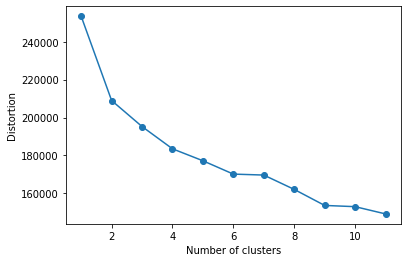

In [8]:
# electricity cutomers are made to fit a 'profile class' which is used in building settlement codes
# all of these customers would currently be profile class 02 - domestic standard rate (e.g. not economy7 etc)

# https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/LoadProfile/Load_Profiles.pdf

# here we do some simple clustering to ascertain whether further divisions of the profile class might be beneficial
# in the future
X = smart_meter_data.iloc[:,2:].values
Xt = X.transpose()
print(Xt)

distortions = []
for i in range(1, 12):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    km.fit(Xt)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 12), distortions, marker='o')
plt.title('k-means clustering - elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [9]:
# elbow method suggests six profile classes
km = KMeans(n_clusters=6, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(Xt)
y_km

array([2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 4, 3, 3, 4, 3, 3, 2, 2, 3, 3, 4, 3,
       3, 4, 2, 2, 2, 0, 3, 2, 2, 2, 3, 3, 2, 3, 4, 2, 2, 3, 4, 0, 0, 4,
       2, 2, 4, 0, 4, 2, 4, 3, 0, 3, 0, 2, 3, 3, 2, 3, 2, 2, 4, 4, 3, 3,
       2, 3, 4, 2, 4, 2, 2, 3, 4, 3, 2, 2, 2, 3, 0, 0, 2, 5, 3, 2, 0, 3,
       4, 0, 3, 2, 2, 4, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 5, 4, 3, 3, 0,
       2, 3, 2, 3, 3, 0, 4, 3, 2, 2, 3, 4, 3, 2, 3, 4, 3, 3, 2, 2, 1, 2,
       3, 2, 3, 3, 3, 4, 2, 2, 2, 3, 3, 3, 4, 2, 2, 3, 3, 2, 3, 3, 2, 3,
       4, 3, 3, 3, 2, 2, 0, 2, 2, 2, 2, 3, 5, 3])

In [10]:
# how many in each cluster? are they true clusters or outliers?
unique, counts = np.unique(y_km, return_counts=True)
dict(zip(unique, counts))

{0: 13, 1: 1, 2: 64, 3: 63, 4: 24, 5: 3}

In [27]:
profiles = np.zeros(shape=(6,17520))

for i in trange(len(y_km)):
    r = y_km[i]
    for j in range(17520):
        profiles[y_km[i]][j] += Xt[y_km[i]][j]
                                            
profiles[0] /= 13
profiles[2] /= 64
profiles[3] /= 63
profiles[4] /= 24
profiles[5] /= 3

profiles

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:04<00:00, 41.27it/s]


array([[0.219, 0.241, 0.191, ..., 0.402, 0.491, 0.452],
       [0.006, 0.017, 0.059, ..., 0.015, 0.027, 0.006],
       [0.093, 0.068, 0.078, ..., 0.055, 0.066, 0.057],
       [0.073, 0.059, 0.069, ..., 0.279, 0.142, 0.16 ],
       [0.107, 0.103, 0.103, ..., 0.157, 0.124, 0.071],
       [0.235, 0.201, 0.202, ..., 0.232, 0.172, 0.237]])

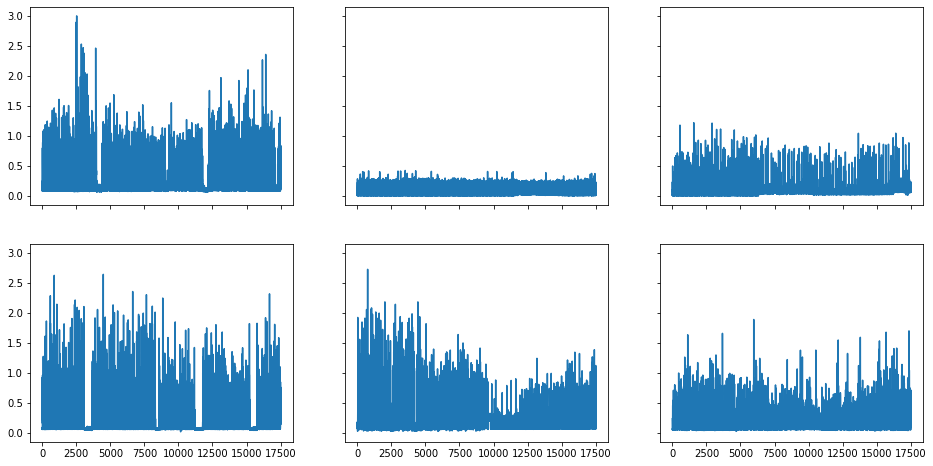

In [45]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16,8))

sns.lineplot(ax=axes[0, 0], data=profiles[0])
sns.lineplot(ax=axes[0, 1], data=profiles[1])
sns.lineplot(ax=axes[0, 2], data=profiles[2])
sns.lineplot(ax=axes[1, 0], data=profiles[3])
sns.lineplot(ax=axes[1, 1], data=profiles[4])
sns.lineplot(ax=axes[1, 2], data=profiles[5])
plt.show()

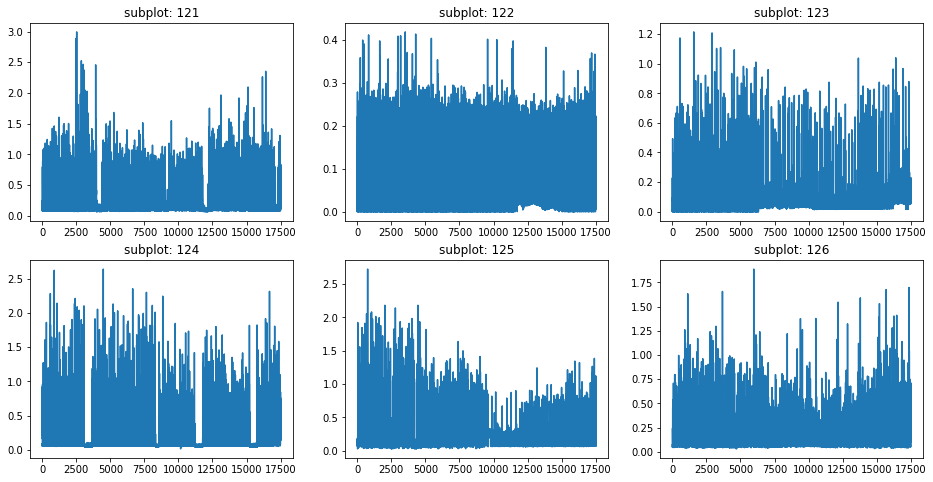

In [46]:
fig = plt.figure(figsize=(16,8))

#  subplot #1
plt.subplot(2,3,1)
plt.title('subplot: 121')
sns.lineplot(data = profiles[0])

#  subplot #2
plt.subplot(2,3,2)
plt.title('subplot: 122')
sns.lineplot(data = profiles[1])

#  subplot #3
plt.subplot(2,3,3)
plt.title('subplot: 123')
sns.lineplot(data = profiles[2])

#  subplot #4
plt.subplot(2,3,4)
plt.title('subplot: 124')
sns.lineplot(data = profiles[3])

#  subplot #5
plt.subplot(2,3,5)
plt.title('subplot: 125')
sns.lineplot(data = profiles[4])

#  subplot #6
plt.subplot(2,3,6)
plt.title('subplot: 126')
sns.lineplot(data = profiles[5])

plt.show()

In [11]:
smart_meter_data['h1'].plot()

,Date,DateTime,h1,h2,h3,h4,h5,h6,h7,h8,...,h159,h160,h161,h162,h163,h164,h165,h166,h167,h168
0,2013-01-01,2013-01-01 00:00:00,0.219,0.006,0.093,0.073,0.107,0.235,0.032,0.076,...,0.100,0.168,0.240,0.076,0.065,0.155,0.209,0.151,0.684,0.105
1,2013-01-01,2013-01-01 00:30:00,0.241,0.017,0.068,0.059,0.103,0.201,0.034,0.075,...,0.095,0.265,0.318,0.053,0.127,0.111,0.230,0.165,0.536,0.087
2,2013-01-01,2013-01-01 01:00:00,0.191,0.059,0.078,0.069,0.103,0.202,0.013,0.073,...,0.059,0.160,0.328,0.037,0.082,0.167,0.187,0.387,0.377,0.050
3,2013-01-01,2013-01-01 01:30:00,0.235,0.000,0.228,0.059,0.130,0.162,0.043,0.073,...,0.084,0.198,0.222,0.036,0.106,0.091,0.109,0.082,0.387,0.045
4,2013-01-01,2013-01-01 02:00:00,0.182,0.000,0.097,0.088,0.078,0.175,0.069,0.072,...,0.098,0.159,0.308,0.051,0.097,0.065,0.168,0.051,0.645,0.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2013-12-31,2013-12-31 21:30:00,0.451,0.056,0.096,0.173,0.140,0.710,0.093,0.087,...,0.142,0.553,0.129,0.247,0.482,0.331,0.308,0.190,1.351,0.095
17516,2013-12-31,2013-12-31 22:00:00,0.456,0.017,0.107,0.166,0.158,0.265,0.104,0.095,...,0.123,0.641,0.164,0.260,0.560,0.237,0.269,0.487,1.954,0.107
17517,2013-12-31,2013-12-31 22:30:00,0.402,0.015,0.055,0.279,0.157,0.232,0.083,0.057,...,0.102,0.613,0.109,0.232,0.425,0.172,0.269,0.147,1.939,0.128
17518,2013-12-31,2013-12-31 23:00:00,0.491,0.027,0.066,0.142,0.124,0.172,0.110,0.033,...,0.102,0.585,0.160,0.258,0.520,0.148,0.182,0.264,1.366,0.056


In [12]:
smart_meter_data.dtypes

Date        datetime64[ns]
DateTime    datetime64[ns]
h1                 float64
h2                 float64
h3                 float64
                 ...      
h164               float64
h165               float64
h166               float64
h167               float64
h168               float64
Length: 170, dtype: object

In [13]:
sdate  = np.min(smart_meter_data['Date'])
edate  = np.max(smart_meter_data['Date'])
dts = list(set(pd.date_range(sdate,edate-timedelta(days=1),freq='d')))
print(sdate, edate, len(dts))

2013-01-01 00:00:00 2013-12-31 00:00:00 364


In [14]:
smart_meter_data.head(20)

,Date,DateTime,h1,h2,h3,h4,h5,h6,h7,h8,...,h159,h160,h161,h162,h163,h164,h165,h166,h167,h168
0,2013-01-01,2013-01-01 00:00:00,0.219,0.006,0.093,0.073,0.107,0.235,0.032,0.076,...,0.100,0.168,0.240,0.076,0.065,0.155,0.209,0.151,0.684,0.105
1,2013-01-01,2013-01-01 00:30:00,0.241,0.017,0.068,0.059,0.103,0.201,0.034,0.075,...,0.095,0.265,0.318,0.053,0.127,0.111,0.230,0.165,0.536,0.087
2,2013-01-01,2013-01-01 01:00:00,0.191,0.059,0.078,0.069,0.103,0.202,0.013,0.073,...,0.059,0.160,0.328,0.037,0.082,0.167,0.187,0.387,0.377,0.050
3,2013-01-01,2013-01-01 01:30:00,0.235,0.000,0.228,0.059,0.130,0.162,0.043,0.073,...,0.084,0.198,0.222,0.036,0.106,0.091,0.109,0.082,0.387,0.045
4,2013-01-01,2013-01-01 02:00:00,0.182,0.000,0.097,0.088,0.078,0.175,0.069,0.072,...,0.098,0.159,0.308,0.051,0.097,0.065,0.168,0.051,0.645,0.061
5,2013-01-01,2013-01-01 02:30:00,0.229,0.000,0.001,0.090,0.081,0.164,0.021,0.072,...,0.058,0.237,0.333,0.049,0.091,0.046,0.078,0.062,1.064,0.058
6,2013-01-01,2013-01-01 03:00:00,0.194,0.064,0.000,0.085,0.111,0.062,0.048,0.072,...,0.080,0.234,0.223,0.044,0.117,0.025,0.131,0.034,0.153,0.045
7,2013-01-01,2013-01-01 03:30:00,0.201,0.004,0.027,0.085,0.171,0.106,0.020,0.032,...,0.098,0.112,0.293,0.034,0.078,0.037,0.092,0.068,0.308,0.045
8,2013-01-01,2013-01-01 04:00:00,0.122,0.000,0.014,0.086,0.081,0.069,0.013,0.065,...,0.055,0.069,0.322,0.194,0.118,0.074,0.096,0.028,0.442,0.045
9,2013-01-01,2013-01-01 04:30:00,0.099,0.000,0.000,0.060,0.064,0.051,0.051,0.073,...,0.081,0.072,0.245,0.326,0.071,0.038,0.125,0.068,0.093,0.045


<AxesSubplot:>

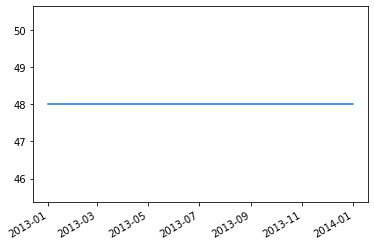

In [15]:
# check all days have 48 (HH) reads
date_counts = smart_meter_data['Date'].value_counts()
#date_counts.plot(kind='bar')
date_counts.plot()

In [16]:
min_pwr  = np.min(smart_meter_data['KWH/hh (per half hour) '])
max_pwr  = np.max(smart_meter_data['KWH/hh (per half hour) '])

print(min_pwr, max_pwr)

KeyError: 'KWH/hh (per half hour) '

In [ ]:
smart_meter_data.head(10)

In [ ]:
day = smart_meter_data[smart_meter_data['Date'] == '2013-09-17']
day.shape

In [ ]:
day.head(len(day))

In [ ]:
# show the days profile
print('max = ', np.min(day['KWH/hh (per half hour) ']))
print('min = ', np.max(day['KWH/hh (per half hour) ']))

plt.plot(day['DateTime'], day['KWH/hh (per half hour) '])


#yticks = np.arange(0, 10, 2)

#plt.ylabel('house 1 demand')
plt.ylabel('Demand kW')
plt.xlabel('Time of day')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
#smart_meter_data.to_csv(dirpath+'/all meters.csv')

In [ ]:
# weather
weather_data = pd.read_csv(dirpath+'/GBR_London.Gatwick.037760_IWEC_copy.epw', sep='\t', 
                           usecols=['year', 'month', 'day', 'hour', 'minute', 
                                    'Global Horizontal Radiation', 'Total Sky Cover'],
                                    low_memory=False)

weather_data.head(10)

In [ ]:
# weather data is hourly but smart meter data is half-hourly
# simply duplicate to half-hourly
modified_weather_data = pd.DataFrame(columns=['DateTime', 'Date', 'Global Horizontal Radiation', 'Total Sky Cover'])

for i in trange(len(weather_data)):
    
    # ignore the weather data year and match to demand file which is 2013
    new_date = '2013-' + str(weather_data.loc[i,'month']) + '-' + str(weather_data.loc[i,'day'])
    
    # weather data uses hours 1 to 24, we want 0-23, and produce on-hour and half-hour timings
    on_hr = new_date + ' ' + str(weather_data.loc[i,'hour']-1) + ':00:00'
    on_hh = new_date + ' ' + str(weather_data.loc[i,'hour']-1) + ':30:00'
    
    # convert to datetimes
    on_hr = datetime.strptime(on_hr, '%Y-%m-%d %H:%M:%S')
    on_hh = datetime.strptime(on_hh, '%Y-%m-%d %H:%M:%S')
    new_date = datetime.strptime(new_date, '%Y-%m-%d')
    
    ghr = weather_data.loc[i,'Global Horizontal Radiation'] # Wh/m2
    tsc = weather_data.loc[i,'Total Sky Cover'] # 10ths of sky cover, e.g. 2 => 2/10ths cloud
    
    modified_weather_data = modified_weather_data.append({'DateTime': on_hr, 'Date': new_date, 'Global Horizontal Radiation': ghr, 'Total Sky Cover': tsc}, ignore_index=True)
    modified_weather_data = modified_weather_data.append({'DateTime': on_hh, 'Date': new_date, 'Global Horizontal Radiation': ghr, 'Total Sky Cover': tsc}, ignore_index=True)
    

In [ ]:
modified_weather_data.head(30)

In [ ]:
modified_weather_data['Global Horizontal Radiation'].value_counts()

Solar PV class

In [ ]:
from IPython.display import Image
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\smart grid'
Image(dirpath + '/solar-pv.jpg') #, width=1000, height=800)

In [ ]:
class SolarPV():
    
    def __init__(self, kWp, efficiency, performance_ratio):
        self.kWp = kWp
        self.efficiency = efficiency
        self.performance_ratio = performance_ratio
        
    ### sort these functions out when get back to Hayling and have CAT notes
    def output(self, ghi):
        # ghi is in Wh/m2, so divide by 1000 to get kWh
        op = 0.001 * ghi * self.kWp * self.efficiency * self.performance_ratio
        return np.round(op, 3)
    
    ### sort these functions out when get back to Hayling and have CAT notes
    def output2(self, ghi, tsc):
        # account for cloudy sky
        op = 0.001 * ghi * self.kWp * self.efficiency * self.performance_ratio * (1 -(tsc/10))
        return np.round(op, 3)

In [ ]:
pv = SolarPV(4.24, 0.3, 0.8)

generated = []

for i in trange(len(weather_data)):
    generated.append(pv.output(modified_weather_data.loc[i, 'Global Horizontal Radiation']))
    #generated.append(pv.output(modified_weather_data.loc[i, 'Global Horizontal Radiation'], modified_weather_data.loc[i, 'Total Sky Cover']))

In [ ]:
len(generated)

In [ ]:
generated

In [ ]:
np.max(generated)

In [ ]:
pv.output(1828)